# Capacitively Coupled CPBs

This notebook computes the Hamiltonian of the directly coupled qubitcircuit. 

<center><img src="images/circuit - direct coupling.png" width=600 height=600/></center>

We assume it can be reduced to the form

\begin{equation}
    \mathcal{H} = \frac{\Delta_p}{2} \sigma^{(p)}_z + 4 E_c (n^{(t)})^2 - E_J \cos(\phi^{(t)}) + g_\parallel \sigma^{(p)}_z n^{(t)} + g_\perp \sigma^{(p)}_x n^{(t)}
\end{equation}

## Install and Import Required Packages

In [2]:
%%capture out
!pip install matplotlib
!pip install scipy
!pip install matplotlib
!pip install tdqm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg
import scipy.sparse as sparse
import json

from tqdm import tqdm

plt.style.use('science')

## Initialise Constants

In [2]:
h = 6.626e-34
hbar = 1.055e-34
e_charge = 1.60218e-19
flux_quanta = h / (2 * e_charge)

## Construct System Class

In [3]:
class SparseSystem:
    
    def __init__(self, Ejp=121e9, Ejt=200e9, Cjp=8e-15, Cjt=8e-15, Cc=5e-15, Ct=100e-15, alpha=0.4, ng=0.25, flux=0.5, ncut=2):
        self.h = 6.626e-34
        self.hbar = 1.055e-34
        self.e_charge = -1.60218e-19
        self.flux_quanta = self.h / (2 * self.e_charge)
        
        self.Ejp = Ejp * self.h                 # Josephson energy of probe
        self.Ejt = Ejt * self.h                 # Josephson energy of target
        self.Cjp = Cjp                          # Josephson capacitance of probe
        self.Cjt = Cjt                          # Josephson capacitance of target
        self.Ct = Ct                            # Target Capacitor
        self.Cc = Cc                            # Coupling capacitance
        self.ng = ng                            # Reduced gate charge
        self.flux = flux                        # Flux through qubit
        self.ncut = ncut                        # Cut-off threshold for number basis
        self.alpha = alpha
        
        self.init_operators()
        
    def _print_params(self):
        print(f'Ejp:    {self.Ejp}')
        print(f'Ejt:    {self.Ejt}')
        print(f'Cjp:    {self.Cjp}')
        print(f'Cjt:    {self.Cjt}')
        print(f'Ct:    {self.Ct}')
        print(f'Cc:    {self.Cc}')
        print(f'alpha: {self.alpha}')
        print(f'ng:    {self.ng}')
        print(f'flux:  {self.flux}')

    def init_operators(self):
        self.I_cb = sp.sparse.diags(np.ones(2 * self.ncut + 1))   # Identity for qubit (charge basis)
        
        self.q_op_cb = sp.sparse.diags(2 * self.e_charge * np.arange(-self.ncut, self.ncut + 1, dtype=np.complex_))           # Charge operator (charge basis)
        self.ng_op_cb = 2 * self.e_charge * self.ng * self.I_cb
        self.e_iphi_op_cb = sp.sparse.diags(np.ones(2 * self.ncut, dtype=np.complex_), offsets=1)
        
        self.q1_q1_qr = self.tensor4(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb, self.I_cb)
        self.q1_q2_qr = self.tensor4(self.q_op_cb, self.q_op_cb, self.I_cb, self.I_cb)
        self.q1_q3_qr = self.tensor4(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.I_cb)
        self.q1_q4_qr = self.tensor4(self.q_op_cb, self.I_cb, self.I_cb, self.q_op_cb)
        self.q2_q2_qr = self.tensor4(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb)
        self.q2_q3_qr = self.tensor4(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb, self.I_cb)
        self.q2_q4_qr = self.tensor4(self.I_cb, self.q_op_cb, self.I_cb, self.q_op_cb)
        self.q3_q3_qr = self.tensor4(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb), self.I_cb)
        self.q3_q4_qr = self.tensor4(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.q_op_cb)
        self.q4_q4_qr = self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.q_op_cb @ self.q_op_cb)
        
        self.q1_q = self.tensor3(self.q_op_cb, self.I_cb, self.I_cb)
        self.q2_q = self.tensor3(self.I_cb, self.q_op_cb, self.I_cb)
        self.q3_q = self.tensor3(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        
        self.q1_q1_q = self.tensor3(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb)
        self.q1_q2_q = self.tensor3(self.q_op_cb, self.q_op_cb, self.I_cb)
        self.q1_q3_q = self.tensor3(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        self.q2_q2_q = self.tensor3(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb)
        self.q2_q3_q = self.tensor3(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb)
        self.q3_q3_q = self.tensor3(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb))
    
    def tensor3(self, op1, op2, op3):
        return sparse.kron(sparse.kron(op1, op2), op3)
    
    def tensor4(self, op1, op2, op3, op4):
        return sparse.kron(sparse.kron(sparse.kron(op1, op2), op3), op4)
    
    def hc(self, state):
        return np.conjugate(state).T
        
    def get_kin_pt(self):
        self.init_operators()
        
        C_mat = [
            [(1 + self.alpha) * self.Cjp, 0, -self.alpha * self.Cjp, 0],
            [0, (1 + self.alpha) * self.Cjp, -self.alpha * self.Cjp, 0],
            [-self.alpha * self.Cjp, -self.alpha * self.Cjp, 2 * self.alpha * self.Cjp + self.Cc, -self.Cc],
            [0, 0, -self.Cc, self.Cjt + self.Cc + self.Ct]
        ]
        
        C_mat_in = np.linalg.inv(C_mat)

        kin_pt = C_mat_in[0][0] * self.q1_q1_qr
        kin_pt += C_mat_in[1][1] * self.q2_q2_qr
        kin_pt += C_mat_in[2][2] * self.q3_q3_qr
        kin_pt += C_mat_in[3][3] * self.q4_q4_qr
        kin_pt += 2 * C_mat_in[0][1] * self.q1_q2_qr
        kin_pt += 2 * C_mat_in[0][2] * self.q1_q3_qr
        kin_pt += 2 * C_mat_in[0][3] * self.q1_q4_qr
        kin_pt += 2 * C_mat_in[1][2] * self.q2_q3_qr
        kin_pt += 2 * C_mat_in[1][3] * self.q2_q4_qr
        kin_pt += 2 * C_mat_in[2][3] * self.q3_q4_qr
        
        kin_pt *= 0.5

        return kin_pt

    def get_pot_pt(self):
        self.init_operators()
        
        pot_pt = -self.Ejp * 0.5 * self.tensor4(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.alpha * self.tensor4(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.alpha * self.tensor4(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.tensor4(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb)
        pot_pt += self.Ejp * 2 * (1 + self.alpha) * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.I_cb)
        
        pot_pt += self.Ejt * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.I_cb)        
        pot_pt += -self.Ejt * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T)
        
        return pot_pt
        
    def get_kin_p(self):
        self.init_operators()
        
        C_mat = [
            [(1 + self.alpha) * self.Cjp, 0, -self.alpha * self.Cjp],
            [0, (1 + self.alpha) * self.Cjp, -self.alpha * self.Cjp],
            [-self.alpha * self.Cjp, -self.alpha * self.Cjp, 2 * self.alpha * self.Cjp + self.Cc]
        ]
        
        C_mat_in = np.linalg.inv(C_mat)

        kin_p = C_mat_in[0][0] * self.q1_q1_q
        kin_p += C_mat_in[1][1] * self.q2_q2_q
        kin_p += C_mat_in[2][2] * self.q3_q3_q
        kin_p += 2 * C_mat_in[0][1] * self.q1_q2_q
        kin_p += 2 * C_mat_in[0][2] * self.q1_q3_q
        kin_p += 2 * C_mat_in[1][2] * self.q2_q3_q
        
        kin_p *= 0.5
        
        return kin_p

    def get_pot_p(self):
        self.init_operators()

        pot_p = -self.Ejp * 0.5 * self.tensor3(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb)
        pot_p += -self.Ejp * 0.5 * self.alpha * self.tensor3(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb)
        pot_p += -self.Ejp * 0.5 * self.alpha * self.tensor3(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T)
        pot_p += -self.Ejp * 0.5 * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T)
        pot_p += -self.Ejp * 0.5 * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb)
        pot_p += -self.Ejp * 0.5 * self.tensor3(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb)
        pot_p += self.Ejp * 2 * (1 + self.alpha) * self.tensor3(self.I_cb, self.I_cb, self.I_cb)
        
        return pot_p
        
    def get_kin_t(self):
        self.init_operators()
        
        kin_t = 0.5 * (self.q_op_cb @ self.q_op_cb) / (self.Cjt + self.Ct + self.Cc)

        return kin_t

    def get_pot_t(self):
        self.init_operators()
        
        pot_t = self.Ejt * self.I_cb
        pot_t += -self.Ejt * (self.e_iphi_op_cb + self.e_iphi_op_cb.T)
        
        return pot_t

    def get_H_pt(self):
        self.H_pt = self.get_kin_pt() + self.get_pot_pt()
        self.H_pt.eliminate_zeros()
        
        return self.H_pt

    def get_H_p(self):
        self.H_p = self.get_kin_p() + self.get_pot_p()
        self.H_p.eliminate_zeros()
        
        return self.H_p

    def get_H_t(self):
        self.H_t = self.get_kin_t() + self.get_pot_t()
        
        return self.H_t
    
    def diagonalise_pt(self, update=False):
        if update:
            self.get_H_pt()
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()
        
        self.evals_pt, evecs = sparse.linalg.eigs(
            self.H_pt, k=10, which='SR'
        )
        
        evecs = evecs.T
        self.evecs_pt = [
            sp.sparse.csr_array(evecs[0]),
            sp.sparse.csr_array(evecs[1]),
        ]
        
        return self.evals_pt, self.evecs_pt
    
    def diagonalise_p(self, update=False):
        if update:
            self.get_H_p()
        else:
            try:
                self.H_p
            except AttributeError:
                self.get_H_p()
        
        self.evals_p, evecs = sparse.linalg.eigs(
            self.H_p, k=10, which='SR'
        )
        
        evecs = evecs.T
        self.evecs_p = [
            sp.sparse.csr_array(evecs[0]),
            sp.sparse.csr_array(evecs[1]),
        ]
        
        return self.evals_p, self.evecs_p
    
    def diagonalise_t(self, update=False):
        if update:
            self.get_H_t()
        else:
            try:
                self.H_t
            except AttributeError:
                self.get_H_t()
        
        self.evals_t, evecs = sparse.linalg.eigs(
            self.H_t, k=2, which='SR'
        )
        
        evecs = evecs.T
        self.evecs_t = [
            sp.sparse.csr_array(evecs[0]),
            sp.sparse.csr_array(evecs[1]),
        ]
        
        return self.evals_t, self.evecs_t
    
    def init_qubit_states(self, update=False):
        if update:
            self.diagonalise_p(update=True)
            self.diagonalise_t(update=True)
        else:
            try:
                self.evecs_p
                self.evecs_t
            except AttributeError:
                self.diagonalise_p()
                self.diagonalise_t()

        self.probe_0 = self.evecs_p[0].T
        self.probe_1 = self.evecs_p[1].T
        self.probe_m = 2**-0.5 * (self.probe_0 - self.probe_1)
        self.probe_p = 2**-0.5 * (self.probe_0 + self.probe_1)

        # self.target_0 = self.evecs_t[0].T
        # self.target_1 = self.evecs_t[1].T
        # self.target_m = 2**-0.5 * (self.target_0 - self.target_1)
        # self.target_p = 2**-0.5 * (self.target_0 + self.target_1)
        
        self.target_0 = sp.sparse.csr_matrix((2 * self.ncut + 1,1))
        self.target_0[self.ncut,0] = 1
        self.target_1 = sp.sparse.csr_matrix((2 * self.ncut + 1,1))
        self.target_1[self.ncut + 1,0] = 1
    
    def _plot_qubit_states(self):
        self.init_qubit_states(update=True)
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |0>, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_0))
        plt.plot(np.imag(self.qubit_0))
        plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |1>, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_1))
        plt.plot(np.imag(self.qubit_1))
        plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |+>, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_p))
        plt.plot(np.imag(self.qubit_p))
        plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |->, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_m))
        plt.plot(np.imag(self.qubit_m))
        plt.show()

    def init_prod_states(self, update=False):
        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.probe_0
            except AttributeError:
                self.init_qubit_states()

        self.ket_00 = sp.sparse.kron(self.probe_0, self.target_0)
        self.ket_01 = sp.sparse.kron(self.probe_0, self.target_1)
        self.ket_10 = sp.sparse.kron(self.probe_1, self.target_0)
        self.ket_11 = sp.sparse.kron(self.probe_1, self.target_1)
        self.ket_p1 = sp.sparse.kron(self.probe_p, self.target_0)
        self.ket_p1 = sp.sparse.kron(self.probe_p, self.target_1)
        self.ket_m0 = sp.sparse.kron(self.probe_m, self.target_0)
        self.ket_m1 = sp.sparse.kron(self.probe_m, self.target_1)
    
    def calc_delta_p(self, update=False):
        if update:
            self.get_H_pt()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()

        delta_p = (self.hc(self.ket_10).dot(self.H_pt.dot(self.ket_10)) - self.hc(self.ket_00).dot(self.H_pt.dot(self.ket_00))).toarray()[0][0]
        
        return delta_p
    
    def calc_delta_t(self, update=False):
        if update:
            self.get_H_pt()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()

        delta_t = (self.hc(self.ket_01).dot(self.H_pt.dot(self.ket_01)) - self.hc(self.ket_00).dot(self.H_pt.dot(self.ket_00))).toarray()[0][0]

        return delta_t
    
    def calc_g_parr(self, update=False):
        if update:
            self.get_H_pt()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_parr = self.hc(self.ket_p1).dot(self.H_pt.dot(self.ket_m1)).toarray()[0][0]
        
        return g_parr
    
    def calc_g_perp(self, update=False):
        if update:
            self.get_H_pt()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_perp = self.hc(self.ket_11).dot(self.H_pt.dot(self.ket_01)).toarray()[0][0]
        
        return g_perp


## Visualise Hamiltonians

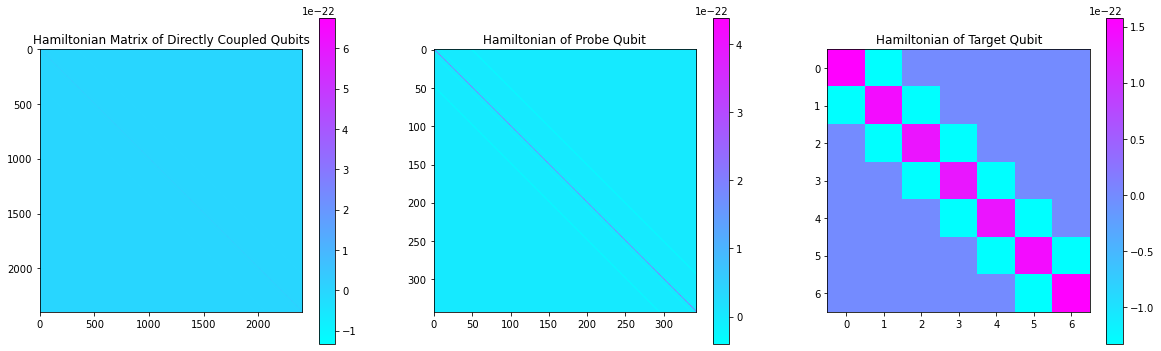

In [77]:
system = SparseSystem(ncut=3)

H_pt = system.get_H_pt()
H_p = system.get_H_p()
H_t = system.get_H_t()

if type(H_pt) == scipy.sparse.csr_matrix:
    H_pt = H_pt.toarray()
    H_p = H_p.toarray()
    H_t = H_t.toarray()

f = plt.figure(figsize=(20,6))

ax1 = f.add_subplot(131)
ax1.title.set_text('Hamiltonian Matrix of Directly Coupled Qubits')
im1 = ax1.imshow(np.real(H_pt), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(132)
ax2.title.set_text('Hamiltonian of Probe Qubit')
im2 = ax2.imshow(np.real(H_p), cmap=plt.get_cmap('cool'))
f.colorbar(im2)

ax3 = f.add_subplot(133)
ax3.title.set_text('Hamiltonian of Target Qubit')
im3 = ax3.imshow(np.real(H_t), cmap=plt.get_cmap('cool'))
f.colorbar(im3)

plt.show()

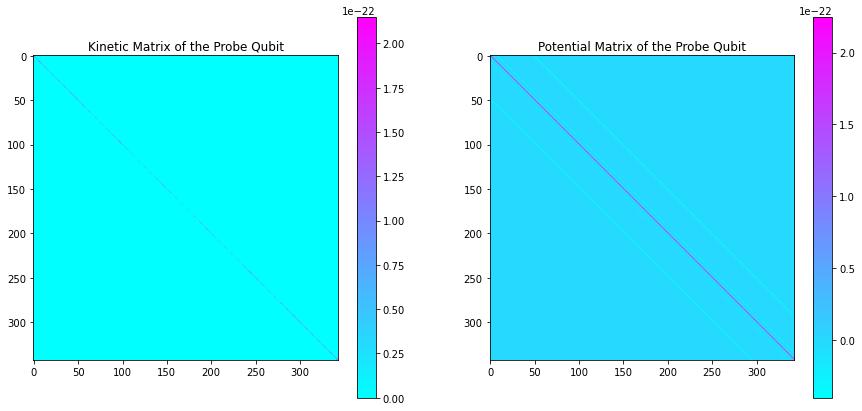

In [78]:
system = SparseSystem(ncut=3)

kin_p = system.get_kin_p()
pot_p = system.get_pot_p()

if type(kin_p) == scipy.sparse.csr_matrix:
    kin_p = kin_p.toarray()
    pot_p = pot_p.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Probe Qubit')
im1 = ax1.imshow(np.real(kin_p), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Probe Qubit')
im2 = ax2.imshow(np.real(pot_p), cmap=plt.get_cmap('cool'))
f.colorbar(im2)
plt.show()

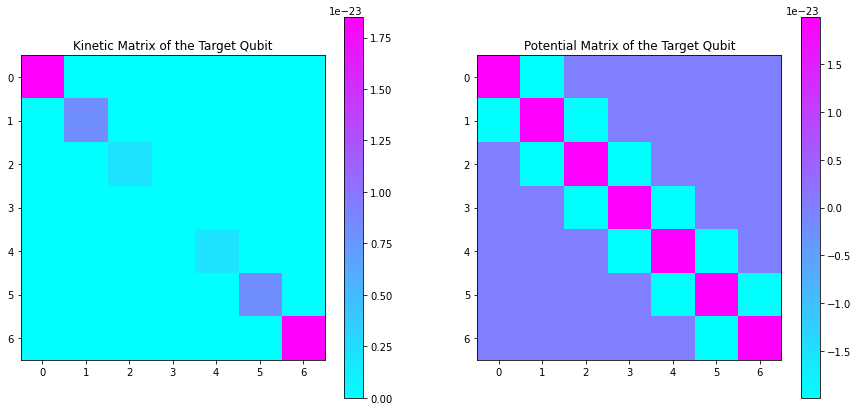

In [79]:
system = SparseSystem(ncut=3, Cjt=1e-14, Ct=1e-14, Ejt=30e9)

kin_t = system.get_kin_t()
pot_t = system.get_pot_t()

if type(kin_t) == scipy.sparse.csr_matrix:
    kin_t = kin_t.toarray()
    pot_t = pot_t.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Target Qubit')
im1 = ax1.imshow(np.real(kin_t), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Target Qubit')
im2 = ax2.imshow(np.real(pot_t), cmap=plt.get_cmap('cool'))
f.colorbar(im2)
plt.show()

# Determine Approximate Hamiltonian Parameters

We assume that the Hamiltonian can be approximated by

\begin{equation}
    \mathcal{H} = \frac{\Delta_p}{2} \sigma^{(p)}_z + \frac{\Delta_t}{2} \sigma^{(t)}_z + g_\parallel \sigma^{(p)}_z n^{(t)} + g_\perp \sigma^{(p)}_x n^{(t)}
\end{equation}

In [80]:
sys = SparseSystem(ncut=3)

H_pt = sys.get_H_pt()

evals_p, evecs_p = sys.diagonalise_p()
evals_t, evecs_t = sys.diagonalise_t()

ket_p_0 = evecs_p[0].T
ket_p_1 = evecs_p[1].T
ket_t_0 = evecs_t[0].T
ket_t_1 = evecs_t[1].T

ket_00 = sp.sparse.kron(ket_p_0, ket_t_0)
ket_10 = sp.sparse.kron(ket_p_1, ket_t_0)
ket_01 = sp.sparse.kron(ket_p_0, ket_t_1)
ket_11 = sp.sparse.kron(ket_p_1, ket_t_1)

In [81]:
delta_p = sys.calc_delta_p()
delta_t = sys.calc_delta_t()
g_parr = sys.calc_g_parr()
g_perp = sys.calc_g_perp()

print(f'∆_p: {np.real(delta_p)}')
print(f'∆_t: {np.real(delta_t)}')
print(f'g_parr: {np.real(g_parr)}')
print(f'g_perp: {np.real(g_perp)}')

∆_p: 1.4019130810903916e-24
∆_t: 3.808798539926488e-24
g_parr: -9.162690175939333e-26
g_perp: -8.594376936152944e-37


/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


## Figure 17a

In [5]:
system = SparseSystem(ncut=4, Cc=0)
fig17a_ngs = np.linspace(-1, 1, 100)
alphas = np.linspace(0.25, 0.6, 2)
fig17a_data_p, fig17a_data_t = {}, {}

for alpha in alphas:
    system.alpha = alpha
    fig17a_data_p[alpha] = []
    fig17a_data_t[alpha] = []
    for ng in tqdm(fig17a_ngs):
        system.ng = ng

        # Full Hamiltonina Approach
        delta_p = system.calc_delta_p(update=True)
        delta_t = system.calc_delta_t()
        
        fig17a_data_p[alpha].append(delta_p)
        fig17a_data_t[alpha].append(delta_t)

  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.90it/s]


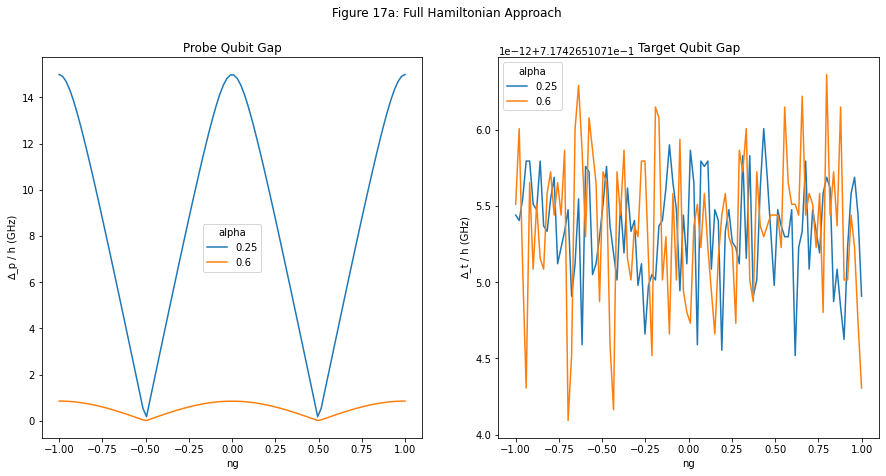

In [6]:
f = plt.figure(figsize=(15,7))
f.suptitle('Figure 17a: Full Hamiltonian Approach')

ax1 = f.add_subplot(121)
ax1.title.set_text('Probe Qubit Gap')
for alpha in fig17a_data_p.keys():
    ax1.plot(fig17a_ngs, [np.abs(np.real(delta * 1e-9)) / h for delta in fig17a_data_p[alpha]], label=round(alpha,2))
ax1.legend(title='alpha')
ax1.set_xlabel('ng')
ax1.set_ylabel('∆_p / h (GHz)')

ax2 = f.add_subplot(122)
ax2.title.set_text('Target Qubit Gap')
for alpha in fig17a_data_t.keys():
    ax2.plot(fig17a_ngs, [np.abs(np.real(delta * 1e-9)) / h for delta in fig17a_data_t[alpha]], label=round(alpha,2))
ax2.legend(title='alpha')
ax2.set_xlabel('ng')
ax2.set_ylabel('∆_t / h (GHz)')
plt.show()

## Figure 17b

In [21]:
system = SparseSystem(ncut=6, alpha=0.4)
fig17b_ngs = np.linspace(-1, 1, 200)
Ccs = np.linspace(0, 10e-15, 2)
fig17b_data_p, fig17b_data_t = {}, {}

for Cc in Ccs:
    system.Cc = Cc
    fig17b_data_p[Cc], fig17b_data_t[Cc] = [], []
    for ng in tqdm(fig17b_ngs):
        system.ng = ng

        # Full Hamiltonina Approach
        delta_p = system.calc_delta_p(update=True)
        delta_t = system.calc_delta_t()
        
        fig17b_data_p[Cc].append(delta_p)
        fig17b_data_t[Cc].append(delta_t)

  0%|                                                   | 0/200 [00:00<?, ?it/s]/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 200/200 [01:50<00:00,  1.81it/s]


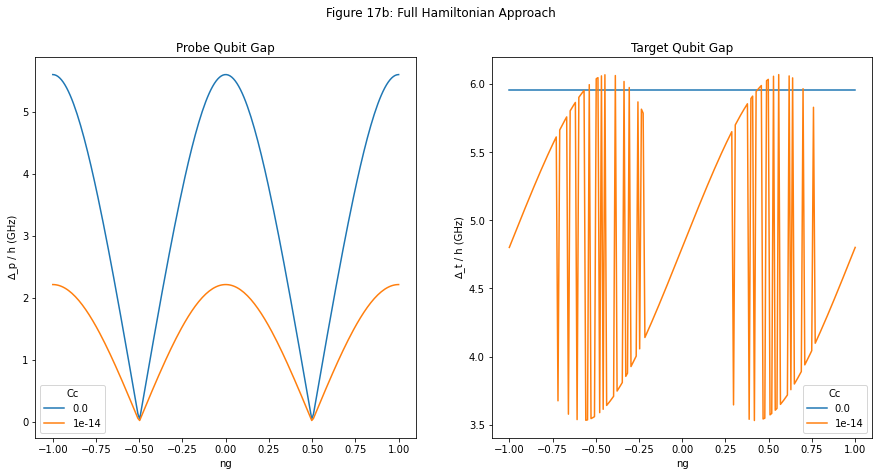

In [22]:
f = plt.figure(figsize=(15,7))
f.suptitle('Figure 17b: Full Hamiltonian Approach')

ax1 = f.add_subplot(121)
ax1.title.set_text('Probe Qubit Gap')
for Cc in fig17b_data_p.keys():
    ax1.plot(fig17b_ngs, [np.abs(np.real(delta * 1e-9)) / h for delta in fig17b_data_p[Cc]], label=Cc)
ax1.legend(title='Cc')
ax1.set_xlabel('ng')
ax1.set_ylabel('∆_p / h (GHz)')

ax2 = f.add_subplot(122)
ax2.title.set_text('Target Qubit Gap')
for Cc in fig17b_data_t.keys():
    ax2.plot(fig17b_ngs, [np.abs(np.real(delta * 1e-9)) / h for delta in fig17b_data_t[Cc]], label=Cc)
ax2.legend(title='Cc')
ax2.set_xlabel('ng')
ax2.set_ylabel('∆_t / h (GHz)')
plt.show()

## Figure 17c

In [6]:
system = SparseSystem(ncut=5, alpha=0.4)
fig17c_ngs = np.linspace(-1, 1, 100)
fig_17c_Ccs = [0, 1e-16, 1e-15, 1e-14]
fig_17c_Ccs_plot = ['0', '0.1', '1', '10']
fig17c_data = {}

for Cc in fig_17c_Ccs:
    system.Cc = Cc
    fig17c_data[Cc] = {
        'g_parr': [],
        'g_perp': []
    }
    for ng in tqdm(fig17c_ngs):
        system.ng = ng

        # Full Hamiltonina Approach
        g_parr = system.calc_g_parr(update=True)
        fig17c_data[Cc]['g_parr'].append(g_parr)

        # Full Hamiltonina Approach
        g_perp = system.calc_g_perp()
        fig17c_data[Cc]['g_perp'].append(g_perp)

  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 100/100 [00:32<00:00,  3.03it/s]


NameError: name 'fig17c_data' is not defined

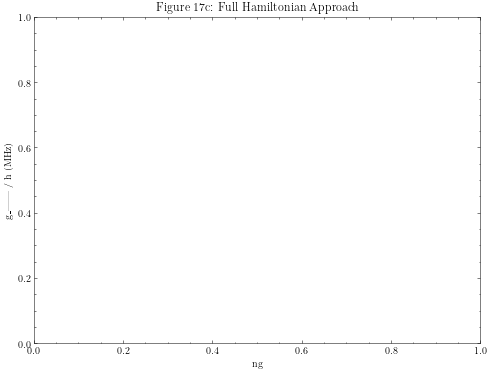

In [5]:
plt.figure(figsize=(8,6))
plt.title('Figure 17c: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('g_|| / h (MHz)')
for Cc in fig17c_data.keys():
    plt.plot(fig17c_ngs, [np.abs(g_parr * 1e-6) / h for g_parr in fig17c_data[Cc]['g_parr']], label=Cc)
plt.legend(title='Cc')
plt.show()

plt.figure(figsize=(8,6))
plt.title('Figure 17c: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('g_perp / h (MHz)')
for Cc in fig17c_data.keys():
    plt.plot(fig17c_ngs, [np.abs(g_perp * 1e-6) / h for g_perp in fig17c_data[Cc]['g_perp']], label=Cc)
plt.legend(title='Cc')
plt.show()

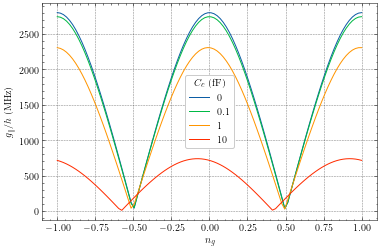

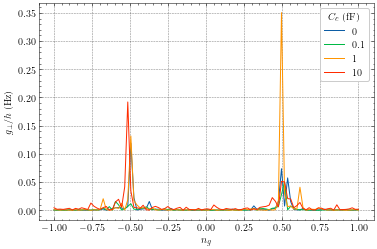

In [8]:
pparam = dict(xlabel='$n_g$', ylabel='$g_\parallel / h$ (MHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for idx, Cc in enumerate(fig17c_data.keys()):
        ax.plot(fig17c_ngs, [np.abs(g_parr * 1e-6) / h for g_parr in fig17c_data[Cc]['g_parr']], label=fig_17c_Ccs_plot[idx])
    ax.legend(title='$C_c$ (fF)')
    ax.set(**pparam)
    fig.savefig('figures/Direct Coupling/g_parr_wrt_ng.png', dpi=300)
    plt.show()

pparam = dict(xlabel='$n_g$', ylabel='$g_\perp / h$ (Hz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for idx, Cc in enumerate(fig17c_data.keys()):
        ax.plot(fig17c_ngs, [np.abs(g_parr) / h for g_parr in fig17c_data[Cc]['g_perp']], label=fig_17c_Ccs_plot[idx])
    ax.legend(title='$C_c$ (fF)')
    ax.set(**pparam)
    fig.savefig('figures/Direct Coupling/g_perp_wrt_ng.png', dpi=300)
    plt.show()

## Figure 17d

In [27]:
fig_17d_Ccs = np.linspace(0, 10e-15, 20)

system = SparseSystem(ncut=4, alpha=0.4, ng=0.25)

fig17d_data = []

for Cc in tqdm(fig_17d_Ccs):
    system.Cc = Cc

    # Full Hamiltonina Approach
    g_parr = system.calc_g_parr(update=True)
    fig17d_data.append(g_parr)

  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 100/100 [00:21<00:00,  4.66it/s]


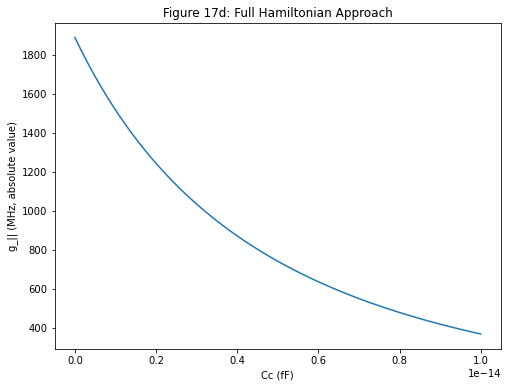

In [28]:
plt.figure(figsize=(8,6))
plt.title('Figure 17d: Full Hamiltonian Approach')
plt.xlabel('Cc (fF)')
plt.ylabel('g_|| (MHz, absolute value)')

plt.plot(fig_17d_Ccs, [abs(val) * 1e-6 / h for val in fig17d_data])
plt.show()